# AVL demo notebook 3: geoDB and vector data

This notebook demonstrates how to read, plot, manipulate and save vector data from AVL’s [geoDB database server](https://xcube-geodb.readthedocs.io/en/latest/).

First we import some required libraries.

In [1]:
from xcube_geodb.core.geodb import GeoDBClient
import matplotlib.pyplot as plt

Create a geoDB client for the AVL geoDB database.

In [2]:
geodb_client = GeoDBClient(database='avl')

List the collections available to us in the current database.

In [3]:
geodb_client.get_my_collections(database='avl')

,owner,database,collection
0,geodb_17c146f6-e133-4ab9-8c9b-6eef968876d6,avl,lpis_belgium
1,geodb_17c146f6-e133-4ab9-8c9b-6eef968876d6,avl,lpis_france
2,geodb_17c146f6-e133-4ab9-8c9b-6eef968876d6,avl,lpis_wallonia
3,geodb_17c146f6-e133-4ab9-8c9b-6eef968876d6,avl,lpis_wallonia_2019
4,geodb_17c146f6-e133-4ab9-8c9b-6eef968876d6,avl,lpis_wallonia_full
5,geodb_17c146f6-e133-4ab9-8c9b-6eef968876d6,avl,soil_map_wallonia


Define a bounding box for our area of interest.

In [4]:
bbox = [-2.0, 47.0, -1.75, 47.1]

Read all the entries in the `lpis_france` collection which intersect with the defined bounding box. Note the use of the `bbox_crs` parameter: the bounding box is defined in WGS 1984 (EPSG 4326), and geoDB will automatically convert it from this CRS to the collection’s CRS.

In [5]:
gdf = geodb_client.get_collection_by_bbox(
    collection='lpis_france',
    comparison_mode='intersects',
    bbox=bbox, 
    bbox_crs=4326
)

Let’s check the CRS of the retrieved data.

In [6]:
gdf.crs

<Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica.
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

The data is in EPSG 2154, a standard projection for France. For convenience, we create a new GeoDataFrame with the data reprojected to EPSG 4326 (WGS 1984).

In [7]:
gdf_wgs = gdf.to_crs(epsg=4326)

We can use the `head` method to take a quick look at the first few lines of the collection; this is often useful for sanity checks.

In [8]:
gdf_wgs.head()

,id,created_at,modified_at,geometry,ori_crop,id_parcel,code_cultu,code_group,cropnum,cropname,...,ctnuml4a,ctl4a,ctnumdiv,ctdiv,eaa,al,pgrass,tgrass,fallow,cwater
0,132,2021-08-17T11:52:51.390119+00:00,None,"MULTIPOLYGON (((-1.84988 47.01636, -1.85014 47...",91,15125777.0,BVF,16.0,91,Sugar beet,...,91,Sugar beet,91,Sugar beet,1,1,0,0,0,0
1,170,2021-08-17T11:52:51.390119+00:00,None,"MULTIPOLYGON (((-1.99233 47.05193, -1.99237 47...",1051,4694368.0,PPH,18.0,1051,Grassland,...,1051,Grassland,10051,Grassland,1,1,0,0,0,0
2,251,2021-08-17T11:52:51.390119+00:00,None,"MULTIPOLYGON (((-1.92242 47.07965, -1.92242 47...",1052,10404704.0,TRE,16.0,1052,Other green cover,...,1052,Other green cover,58,Sainfoin,1,1,0,0,0,0
3,266,2021-08-17T11:52:51.390119+00:00,None,"MULTIPOLYGON (((-1.80300 47.09685, -1.80236 47...",1052,12644161.0,FLA,25.0,1052,Other green cover,...,1052,Other green cover,58,Sainfoin,1,1,0,0,0,0
4,394,2021-08-17T11:52:51.390119+00:00,None,"MULTIPOLYGON (((-1.96431 47.06442, -1.96439 47...",753,15169475.0,BTA,28.0,753,Buffer strip (along ?),...,753,Buffer strip (along ?),753,Buffer strip (along ?),1,1,0,0,0,0


Now we plot the data in the notebook, colour-coding the polygons by crop name. With 49 crop types it’s not possible to create a colour map which clearly distinguishes every possible value, but we can at least give some indication of the variety. Note the slight diagonal truncations of the data in the upper left and lower right corners: the data was initially retrieved with a bounding box transformed to the dataset’s original CRS, which is slightly skewed relative to the current WGS 1984 CRS.

<AxesSubplot:>

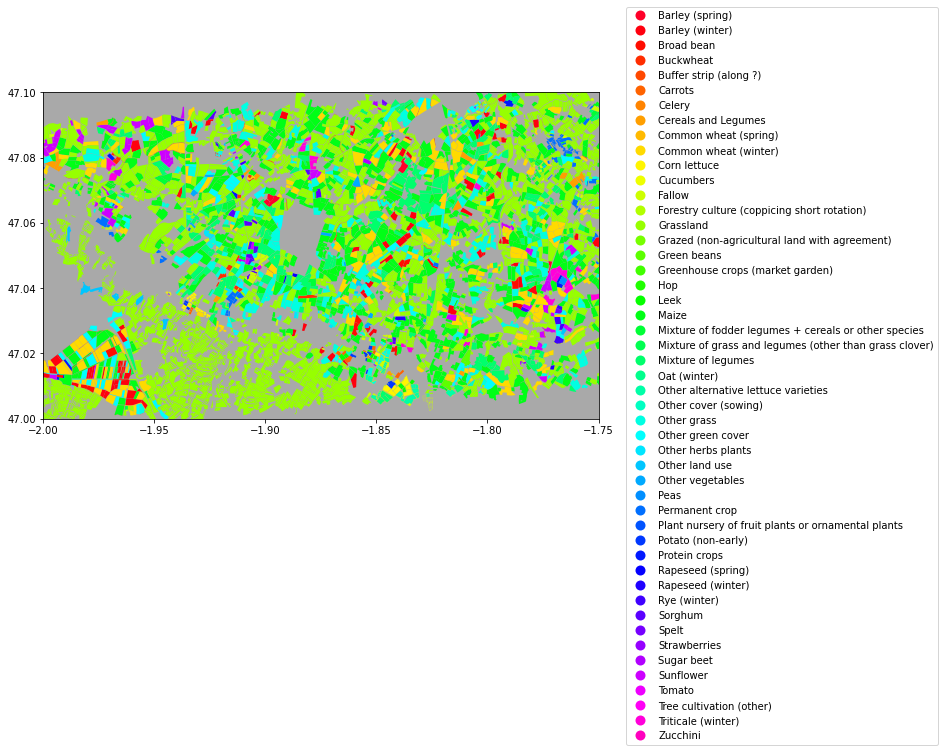

In [9]:
fig, ax = plt.subplots(figsize=(20,6))
ax.set_xlim([bbox[0], bbox[2]])
ax.set_ylim([bbox[1], bbox[3]])
ax.set_facecolor('darkgray')
gdf_wgs.plot('cropname',
             cmap='gist_rainbow', 
             legend=True,
             ax=ax,
             legend_kwds=dict(loc=(1.05, -1)))

Finally, save the reprojected data to a file in the JupyterLab workspace.

In [10]:
gdf_wgs.to_file('crops.gpkg', driver='GPKG')